In [1]:
#import libraries
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb


In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d sergeymedvedev/customer_segmentation

 69% 5.00M/7.20M [00:00<00:00, 50.7MB/s]
100% 7.20M/7.20M [00:00<00:00, 60.2MB/s]


In [9]:
!unzip customer_segmentation.zip

Archive:  customer_segmentation.zip
replace customer_segmentation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: customer_segmentation.csv  


In [12]:
tx_data = pd.read_csv('/content/customer_segmentation.csv', encoding='cp1252')
tx_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Feature Engineering

In [13]:
#converting the type of Invoice Date Field from string to datetime.
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [14]:
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [15]:
tx_data.describe()

,Quantity,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,201099.713989
std,218.081158,96.759853,1713.600303,25.788703
min,-80995.000000,-11062.060000,12346.000000,201012.000000
25%,1.000000,1.250000,13953.000000,201103.000000
50%,3.000000,2.080000,15152.000000,201107.000000
75%,10.000000,4.130000,16791.000000,201110.000000
max,80995.000000,38970.000000,18287.000000,201112.000000


In [16]:
tx_data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [17]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)


#Recency


In [18]:
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [19]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [20]:
#max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [21]:
# Comparing the last transaction of the dataset with last transaction dates of the individual customer IDs.
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [22]:
#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


# Assigning recency score

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

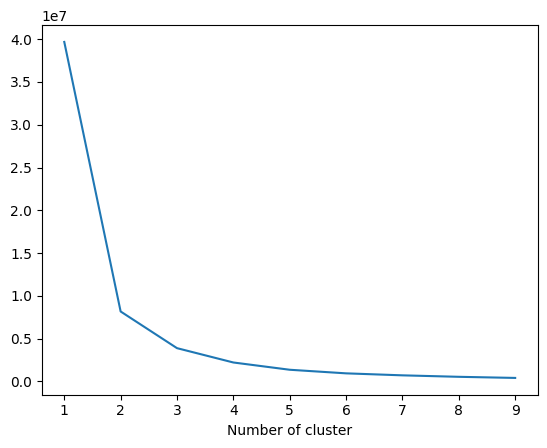

In [23]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=4)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [25]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,329,1
4,15291.0,25,0


In [26]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0


# Ordering clusters

In [27]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [28]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [29]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


#Frequency

In [30]:
#getting order counts for each user and creating a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [31]:
tx_frequency.head() #how many orders does a customer have

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [32]:
#adding this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


# Frequency clusters

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-e2bfb8ed226b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-e2bfb8ed226b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

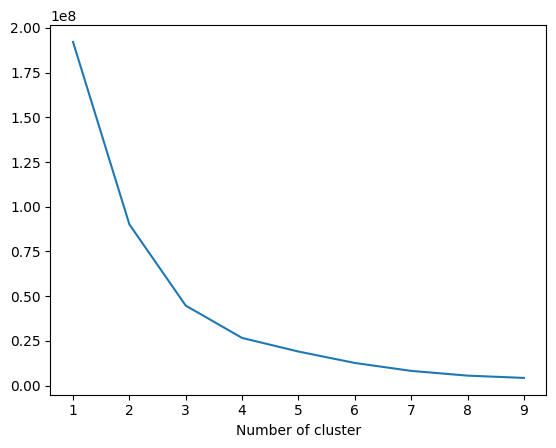

In [33]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [34]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
tx_user['FrequencyCluster']=kmeans.fit_predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True )
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


# Clustering based on Revenue

In [35]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [36]:
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [37]:
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-38-3ebb744cc7b2>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-38-3ebb744cc7b2>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

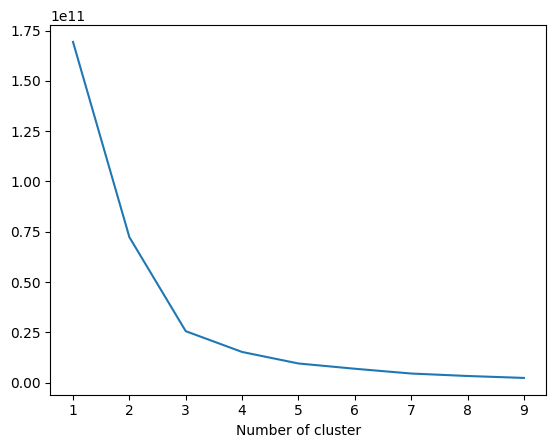

In [38]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values 
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

# Revenue clusters


In [39]:
#apply clustering
kmeans = KMeans(n_clusters=4)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']])

#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# RFM Score

In [40]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

<ipython-input-40-ad2f8ed87503>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [41]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [42]:
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value
...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8,High-Value
3946,17841.0,1,3,7983,3,40340.78,2,8,High-Value
3947,14096.0,3,3,5128,3,57120.91,2,8,High-Value
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value


# Customer Lifetime Value for six months

In [43]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [44]:
tx_uk['InvoiceDate'].describe()

<ipython-input-44-a12594270851>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  495478
unique                  21220
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

In [50]:
from datetime import datetime

tx_3m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,6,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True) #3 months time
tx_6m = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,6,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True) # 6 months time

In [51]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [52]:
tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [53]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [54]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [55]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [56]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left') #Only people who are in the timeline of tx_user_6m

In [57]:
tx_merge = tx_merge.fillna(0)


In [58]:
tx_graph = tx_merge.query("m6_Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [59]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [60]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00
1,14688.0,7,3,359,1,5107.38,1,5,High-Value,1702.06
4,14849.0,21,3,392,1,7904.28,1,5,High-Value,5498.07
6,13468.0,1,3,306,1,5656.75,1,5,High-Value,1813.09
7,17690.0,29,3,258,1,4748.45,1,5,High-Value,2616.15


In [61]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m6_Revenue']])

tx_merge.head()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.00,0
1,14688.0,7,3,359,1,5107.38,1,5,High-Value,1702.06,2
4,14849.0,21,3,392,1,7904.28,1,5,High-Value,5498.07,1
6,13468.0,1,3,306,1,5656.75,1,5,High-Value,1813.09,2
7,17690.0,29,3,258,1,4748.45,1,5,High-Value,2616.15,2


In [62]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2955.0,276.176333,280.962101,-4287.63,0.0000,228.910,449.425,937.60
1,799.0,1605.393279,550.258391,938.20,1143.6650,1479.840,1933.495,3113.70
2,156.0,4645.661795,1345.674897,3129.27,3537.7325,4256.115,5497.980,8432.68


In [63]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value,0.0,0
1,13093.0,266,0,170,0,7741.47,1,1,Low-Value,0.0,0
2,15032.0,255,0,55,0,4464.10,1,1,Low-Value,0.0,0
3,16000.0,2,3,9,0,12393.70,1,4,Mid-Value,0.0,0
4,15749.0,234,1,15,0,21535.90,1,2,Low-Value,0.0,0


#Feature Engineering

In [64]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,1,2,0.0,0,0,1,0
1,13093.0,266,0,170,0,7741.47,1,1,0.0,0,0,1,0
2,15032.0,255,0,55,0,4464.10,1,1,0.0,0,0,1,0
3,16000.0,2,3,9,0,12393.70,1,4,0.0,0,0,0,1
4,15749.0,234,1,15,0,21535.90,1,2,0.0,0,0,1,0


In [65]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)


LTVCluster            1.000000
m6_Revenue            0.877508
Revenue               0.774841
RevenueCluster        0.604372
Frequency             0.569080
OverallScore          0.542623
FrequencyCluster      0.515422
Segment_High-Value    0.495977
RecencyCluster        0.359110
Segment_Mid-Value     0.190712
CustomerID           -0.030966
Recency              -0.351114
Segment_Low-Value    -0.379459
Name: LTVCluster, dtype: float64

In [66]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

# XGBOOST Model for Customer Lifetime Value Prediction

In [67]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.91


In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       144
           1       0.76      0.89      0.82        44
           2       0.86      0.75      0.80         8

    accuracy                           0.91       196
   macro avg       0.86      0.86      0.86       196
weighted avg       0.92      0.91      0.92       196

